# Запросы к базе данных

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# import plotly.io as pio
# pio.renderers.default='notebook'

**Диаграмма базы данных**
![Диаграмма базы данных](dvdrentalschema.png)

Для загрузки и работы с базой данных я выбрал `sqlite3`, в принципе синтаксис считывания и работы с базой данных у всех методов практически похож.

In [2]:
database_path = "C:\\Innopolis\\Project_Module_2\\Attestation_2\\archive\\sqlite-sakila.db"


class GetDatabase:
    """
    Класс для загрузки базы данных
    """

    def __init__(self, database_path):
        self.database_path = database_path

    def execute_query(self, query):
        with sqlite3.connect(database_path) as connection:
            cursor = connection.cursor()
            try:
                cursor.execute(query)
                colnames = [desc[0] for desc in cursor.description]
                result = cursor.fetchall()
                return pd.DataFrame(result, columns=colnames)
            except Exception as e:
                print(f"Error: {e}")

db = GetDatabase(database_path)

In [4]:
query_0 = '''
SELECT name, type 
FROM sqlite_master 
WHERE type = 'table'
'''

df_0 = db.execute_query(query_0)
df_0

,name,type
0,store,table
1,staff,table
2,rental,table
3,payment,table
4,language,table
5,inventory,table
6,film_category,table
7,film_actor,table
8,film,table
9,customer,table


## Какова доля фильмов в каждой рейтинговой категории (G, PG, PG-13, R и т.д.) в нашем ассортименте?

In [5]:
query_1 = """
SELECT rating, 
       COUNT(rating) AS movie_count,
       ROUND((COUNT(rating)*100 / (SELECT COUNT(rating) FROM film)), 2) AS part
FROM film
GROUP BY rating
ORDER BY part DESC;
"""

df_1 = db.execute_query(query_1)
df_1.to_csv("./film_rating.csv", index=False)
df_1

,rating,movie_count,part
0,PG-13,223,22.0
1,NC-17,210,21.0
2,R,195,19.0
3,PG,194,19.0
4,G,178,17.0


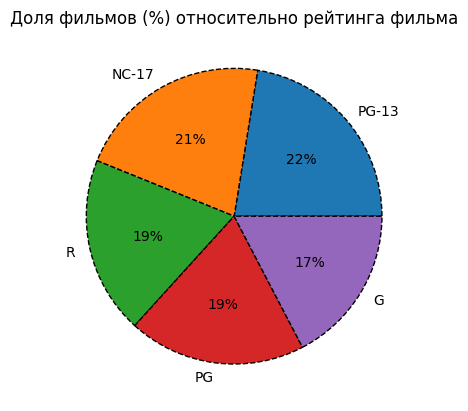

In [6]:

fig, ax = plt.subplots()
ax.pie(
    df_1['part'], 
    labels=df_1['rating'],  
    autopct='%1.0f%%', 
    wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}
)

plt.title("Доля фильмов (%) относительно рейтинга фильма")
plt.show()

## Какие категории фильмов чаще всего арендуются клиентами?

In [7]:
query_2 = """
SELECT c.name AS film_category,
       COUNT(r.rental_id) AS rental_count
FROM rental AS r
JOIN inventory AS i ON r.inventory_id = i.inventory_id
JOIN film AS f ON i.film_id = f.film_id
JOIN film_category AS fc ON f.film_id = fc.film_id
JOIN category AS c ON fc.category_id = c.category_id
GROUP BY c.name
ORDER BY rental_count DESC;
"""

df_2 = db.execute_query(query_2)
df_2.to_csv("./film_category.csv", index=False)
df_2

,film_category,rental_count
0,Sports,1179
1,Animation,1166
2,Action,1112
3,Sci-Fi,1101
4,Family,1096
5,Drama,1060
6,Documentary,1050
7,Foreign,1033
8,Games,969
9,Children,945


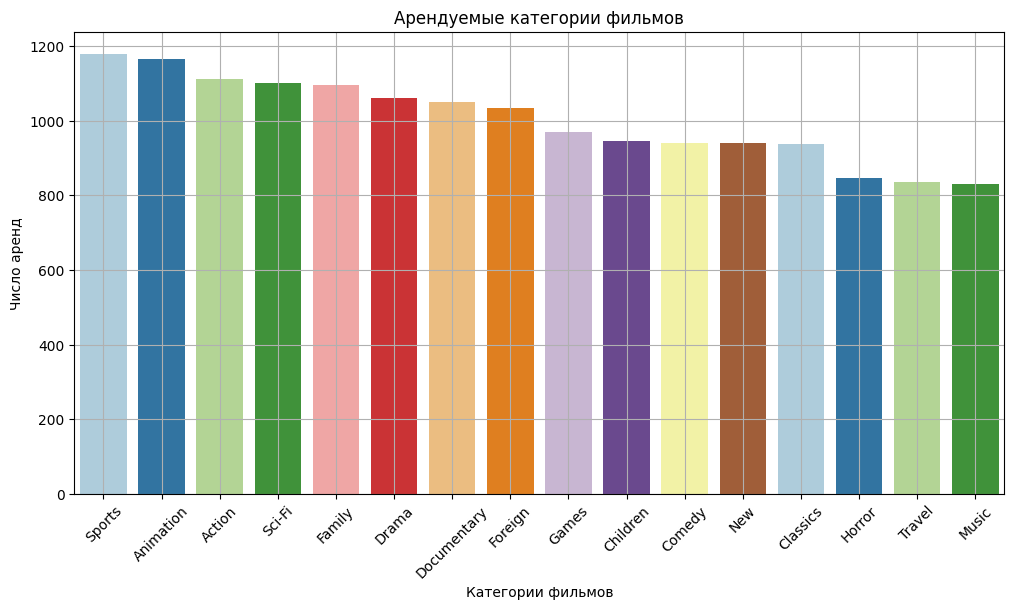

In [8]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_2, 
    y="rental_count", 
    x="film_category", 
    palette='Paired',  
    hue="film_category"
)
plt.ylabel("Число аренд")
plt.xlabel("Категории фильмов")
plt.title("Арендуемые категории фильмов")
plt.xticks(rotation=45)
plt.grid()
plt.show()

## Какова средняя продолжительность проката (rental duration) для каждой категории фильмов?

In [9]:
query_3 = """
SELECT c.name AS film_category, 
       ROUND(AVG(f.rental_duration), 2) AS avg_rental_duration
FROM film AS f
JOIN film_category AS fc ON f.film_id = fc.film_id
JOIN category AS c ON fc.category_id = c.category_id
GROUP BY c.name
ORDER BY avg_rental_duration DESC;
"""

df_3 = db.execute_query(query_3)
df_3.to_csv("./avg_rental_duration.csv", index=False)
df_3

,film_category,avg_rental_duration
0,Travel,5.35
1,Music,5.24
2,Family,5.17
3,Foreign,5.11
4,Drama,5.08
5,Games,5.07
6,Classics,5.07
7,Children,5.03
8,Action,4.95
9,Comedy,4.93


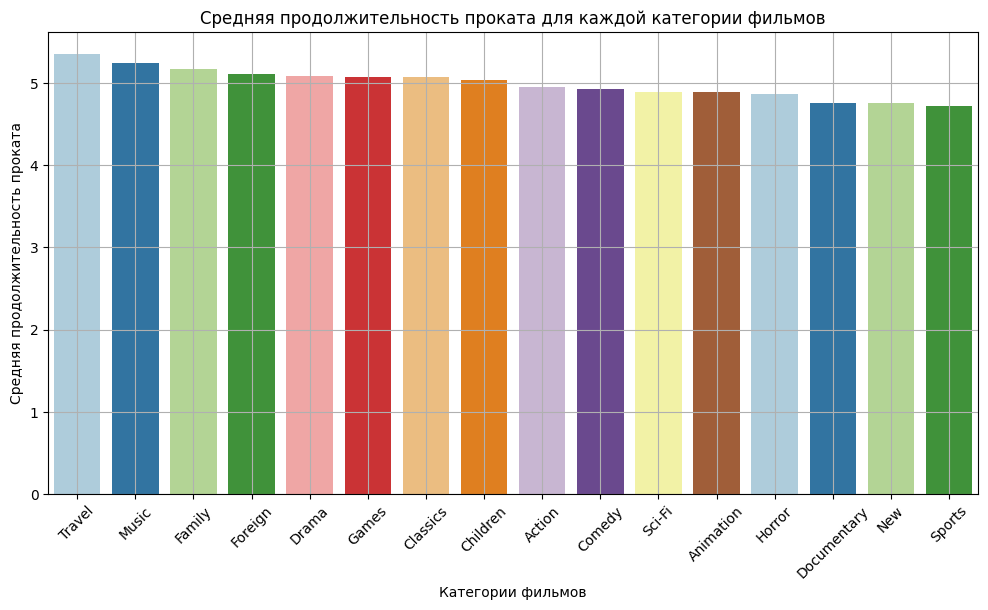

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_3, 
    y="avg_rental_duration", 
    x="film_category", 
    palette='Paired',  
    hue="film_category"
)
plt.ylabel("Средняя продолжительность проката")
plt.xlabel("Категории фильмов")
plt.title("Средняя продолжительность проката для каждой категории фильмов")
plt.xticks(rotation=45)
plt.grid()
plt.show()

## Каковы тенденции в ежемесячном доходе от проката (monthly rental revenue) и продажах (sales) за прошедший год?

In [11]:
query_4 = """
SELECT STRFTIME("%Y-%m", r.rental_date) as year_month, 
       SUM(p.amount) as sum_revenue
FROM rental AS r 
LEFT JOIN payment AS p on r.rental_id = p.rental_id
WHERE STRFTIME("%Y-%m", r.rental_date) LIKE '%2005%'
GROUP BY year_month
ORDER BY year_month ASC
"""

df_4 = db.execute_query(query_4)
df_4.to_csv("./monthly_rental_revenue.csv", index=False)
df_4

,year_month,sum_revenue
0,2005-05,4823.44
1,2005-06,9629.89
2,2005-07,28368.91
3,2005-08,24070.14


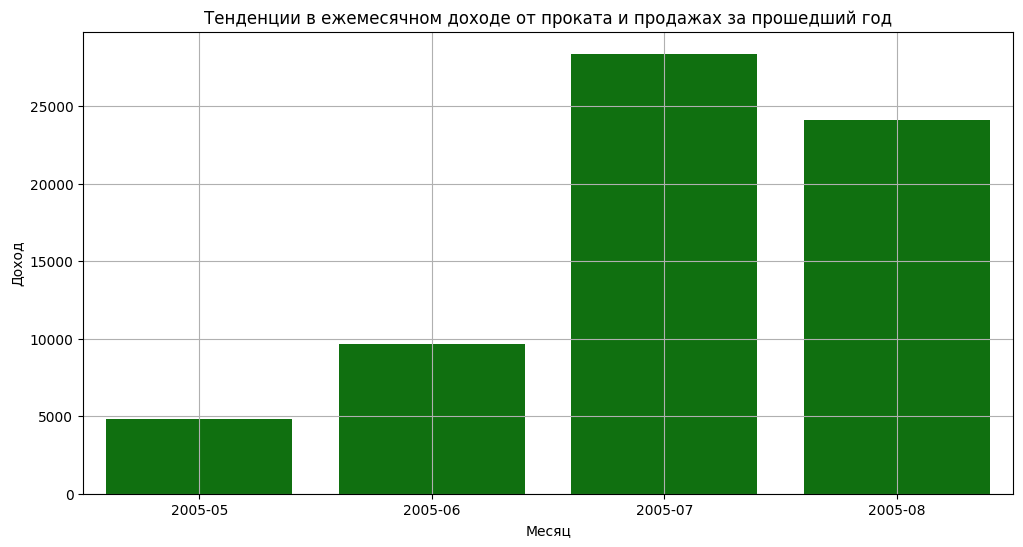

In [12]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_4, 
    y="sum_revenue", 
    x="year_month", 
    color='green'
)
plt.ylabel("Доход")
plt.xlabel("Месяц")
plt.title("Тенденции в ежемесячном доходе от проката и продажах за прошедший год")
plt.grid()
plt.show()

## Как соотносятся показатели продаж в разных магазинах?

In [13]:
query_5 = """
SELECT s.store_id, 
       SUM(p.amount) as revenue_sum,
       COUNT(s.store_id) as units_count,
       ROUND(SUM(p.amount)/COUNT(s.store_id),2) as revenue_per_unit
FROM store AS s 
LEFT JOIN inventory AS i on s.store_id = i.store_id
LEFT JOIN rental AS r on i.inventory_id = r.inventory_id
LEFT JOIN payment AS p on r.rental_id = p.rental_id
GROUP BY s.store_id
ORDER BY s.store_id
"""

df_5 = db.execute_query(query_5)
df_5.to_csv("./store_revenue.csv", index=False)
df_5

,store_id,revenue_sum,units_count,revenue_per_unit
0,1,33679.79,7923,4.25
1,2,33726.77,8122,4.15


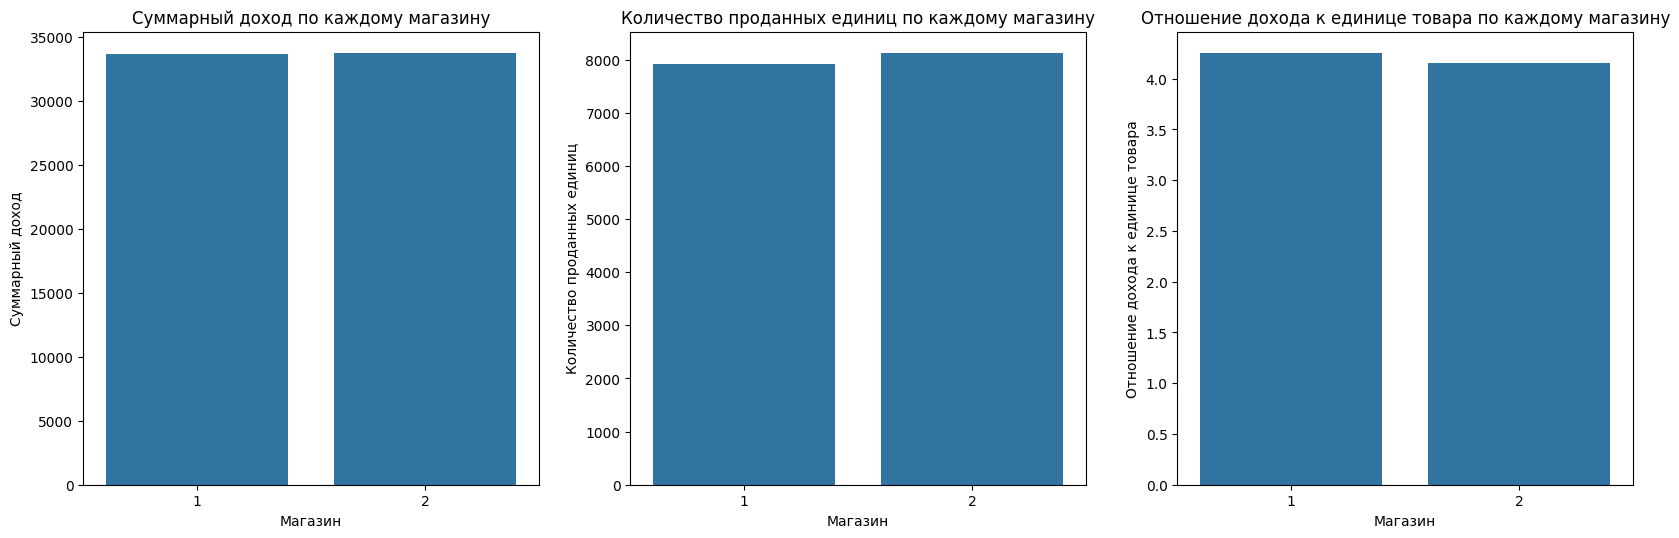

In [14]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 3, 1)
sns.barplot(
    data=df_5, 
    y="revenue_sum", 
    x="store_id"
)
plt.ylabel("Суммарный доход")
plt.xlabel("Магазин")
plt.title("Суммарный доход по каждому магазину")

plt.subplot(3, 3, 2)
sns.barplot(
    data=df_5, 
    y="units_count", 
    x="store_id"
)
plt.ylabel("Количество проданных единиц")
plt.xlabel("Магазин")
plt.title("Количество проданных единиц по каждому магазину")

plt.subplot(3, 3, 3)
sns.barplot(
    data=df_5, 
    y="revenue_per_unit", 
    x="store_id"
)
plt.ylabel("Отношение дохода к единице товара")
plt.xlabel("Магазин")
plt.title("Отношение дохода к единице товара по каждому магазину")

plt.show()

## Каковы средние затраты на замену (replacement_cost) фильмов в разных жанрах?

In [15]:
query_6 = """
SELECT c.name AS category_of_film, 
       ROUND(AVG(f.replacement_cost), 2) AS avg_replacement_cost
FROM film AS f
JOIN film_category AS fc ON f.film_id = fc.film_id
JOIN category AS c ON fc.category_id = c.category_id
GROUP BY c.name
ORDER BY avg_replacement_cost DESC;
"""

df_6 = db.execute_query(query_6)
df_6.to_csv("./replacement_cost.csv", index=False)
df_6

,category_of_film,avg_replacement_cost
0,Sci-Fi,21.15
1,Drama,21.09
2,Classics,21.01
3,Action,20.91
4,Sports,20.40
5,Games,20.29
6,Animation,20.13
7,Children,20.06
8,Horror,19.87
9,Family,19.73


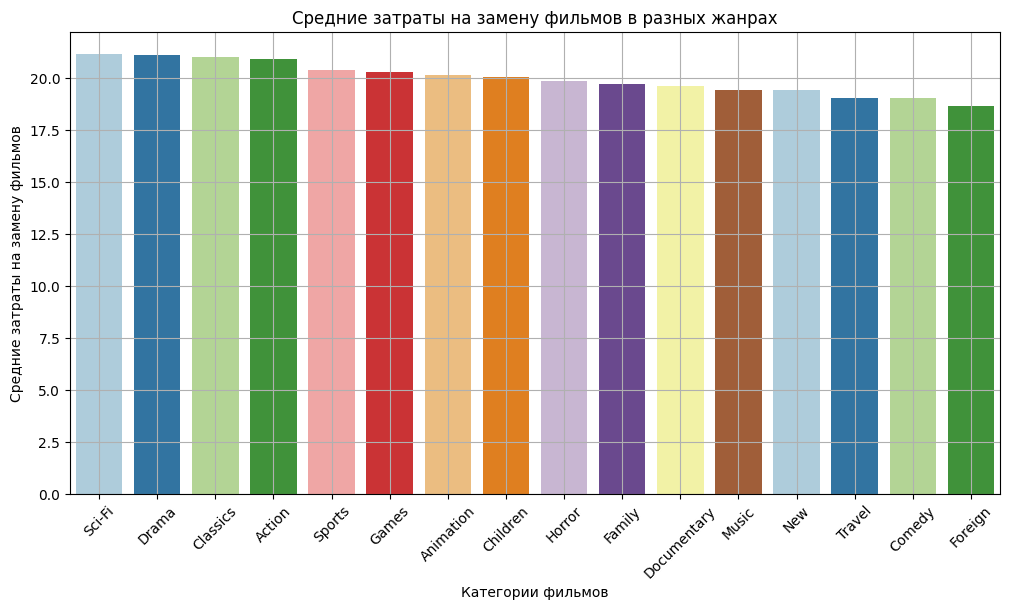

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_6, 
    y="avg_replacement_cost", 
    x="category_of_film", 
    palette='Paired',  
    hue="category_of_film"
)
plt.ylabel("Средние затраты на замену фильмов")
plt.xlabel("Категории фильмов")
plt.title("Средние затраты на замену фильмов в разных жанрах")
plt.xticks(rotation=45)
plt.grid()
plt.show()

## Какие актеры снимаются в самых разных жанрах фильмов?

In [19]:
query_7 = """
SELECT a.actor_id, 
       a.first_name || ' ' || a.last_name AS actor_name, 
       COUNT(DISTINCT c.category_id) AS genre_count,
       GROUP_CONCAT(c.name, ';') AS genre_name
FROM actor AS a
JOIN film_actor AS fa ON a.actor_id = fa.actor_id
JOIN film AS f ON fa.film_id = f.film_id
JOIN film_category AS fc ON f.film_id = fc.film_id
JOIN category AS c ON fc.category_id = c.category_id
GROUP BY a.actor_id, actor_name
ORDER BY genre_count DESC;
"""

df_7 = db.execute_query(query_7)
df_7.to_csv("./actors.csv", index=False)
df_7.head()

,actor_id,actor_name,genre_count,genre_name
0,13,UMA WOOD,16,Music;Action;New;Travel;Children;New;Animation...
1,72,SEAN WILLIAMS,16,Horror;New;Sports;Classics;Travel;Sci-Fi;Anima...
2,95,DARYL WAHLBERG,16,New;Horror;Foreign;Foreign;Horror;Music;Action...
3,106,GROUCHO DUNST,16,Sci-Fi;Family;New;Action;New;Classics;Games;Ac...
4,107,GINA DEGENERES,16,Documentary;Foreign;Music;New;Sci-Fi;Action;Sc...


In [20]:
fig = px.scatter(df_7,
                 x="actor_name", 
                 y="genre_count",
                 title="Актеры и количество жанров в которых они снимаются")
fig.show()

**Скриншот работы графика plotly**
![Скриншот работы графика plotly](plotly_graphic.png)

# Статистический анализ данных

## Объединим таблицы

In [21]:
query_8 = """
SELECT
       a.first_name || ' ' || a.last_name AS actor_name,
       f.title AS film_title,
       f.release_year AS film_release_year,
       f.rental_duration AS film_rental_duration,
       f.rental_rate AS film_rental_rate,
       f.length AS film_length,
       f.replacement_cost AS film_replacement_cost,
       f.rating AS film_rating,
       f.special_features AS film_spec_features,
       c.name AS film_category
FROM actor AS a
JOIN film_actor AS fa ON a.actor_id = fa.actor_id
JOIN film AS f ON fa.film_id = f.film_id
JOIN film_category AS fc ON f.film_id = fc.film_id
JOIN category AS c ON fc.category_id = c.category_id;
"""

df_8 = db.execute_query(query_8)
df_8.to_csv("./joined tables.csv", index=False)
df_8.dtypes

actor_name                object
film_title                object
film_release_year         object
film_rental_duration       int64
film_rental_rate         float64
film_length                int64
film_replacement_cost    float64
film_rating               object
film_spec_features        object
film_category             object
dtype: object

In [22]:
df = pd.read_csv('joined tables.csv')
df.head()

,actor_name,film_title,film_release_year,film_rental_duration,film_rental_rate,film_length,film_replacement_cost,film_rating,film_spec_features,film_category
0,PENELOPE GUINESS,ACADEMY DINOSAUR,2006,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",Documentary
1,PENELOPE GUINESS,ANACONDA CONFESSIONS,2006,3,0.99,92,9.99,R,"Trailers,Deleted Scenes",Animation
2,PENELOPE GUINESS,ANGELS LIFE,2006,3,2.99,74,15.99,G,Trailers,New
3,PENELOPE GUINESS,BULWORTH COMMANDMENTS,2006,4,2.99,61,14.99,G,Trailers,Games
4,PENELOPE GUINESS,CHEAPER CLYDE,2006,6,0.99,87,23.99,G,"Trailers,Commentaries,Behind the Scenes",Sci-Fi


## Разведочный анализ для числовых значений

In [23]:
numeric_col = df.select_dtypes(include=["number"]).columns
numeric_info = pd.DataFrame(
    {
        "Доля пропусков": df[numeric_col].isnull().mean(),
        "Минимальное значение": df[numeric_col].min(), 
        "Максимальное значение": df[numeric_col].max(),
        "Среднее значение": df[numeric_col].mean(), 
        "Медиана": df[numeric_col].median(), 
        "Дисперсия": df[numeric_col].var(), 
        "Квантиль 0.1": df[numeric_col].quantile(0.1), 
        "Квантиль 0.9": df[numeric_col].quantile(0.9), 
        "Квартиль 1": df[numeric_col].quantile(0.25), 
        "Квартиль 3": df[numeric_col].quantile(0.75), 
    }
)

numeric_info.to_csv("./numeric_info.csv", index=False)
numeric_info

,Доля пропусков,Минимальное значение,Максимальное значение,Среднее значение,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
film_release_year,0.0,2006.00,2006.00,2006.000000,2006.00,0.000000,2006.00,2006.00,2006.00,2006.00
film_rental_duration,0.0,3.00,7.00,4.986452,5.00,1.955136,3.00,7.00,4.00,6.00
film_rental_rate,0.0,0.99,4.99,2.957411,2.99,2.658524,0.99,4.99,0.99,4.99
film_length,0.0,46.00,185.00,115.336507,114.00,1655.406977,60.00,173.00,80.00,150.00
film_replacement_cost,0.0,9.99,29.99,20.017829,19.99,36.789557,11.99,27.99,14.99,24.99


## Разведочный анализ для категориальных значений

In [24]:
categorical_col = df.select_dtypes(include=["object"]).columns
categorical_info = pd.DataFrame(
    {
        "Доля пропусков": df[categorical_col].isnull().mean(),
        "Количество уникальных значений": df[categorical_col].nunique(),
        "Мода": df[categorical_col].mode().iloc[0],
    }
)

categorical_info.to_csv("./categorical_info.csv", index=False)
categorical_info

,Доля пропусков,Количество уникальных значений,Мода
actor_name,0.0,199,SUSAN DAVIS
film_title,0.0,997,LAMBS CINCINATTI
film_rating,0.0,5,PG-13
film_spec_features,0.0,15,"Trailers,Commentaries,Behind the Scenes"
film_category,0.0,16,Sports
